# Exploratory Data Analysis (EDA)

## Table of Contents
1. [Dataset Overview](#dataset-overview)
2. [Handling Missing Values](#handling-missing-values)
3. [Feature Distributions](#feature-distributions)
4. [Possible Biases](#possible-biases)
5. [Correlations](#correlations)


. [Correlations](#correlations)


In [78]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Dataset Overview

[Provide a high-level overview of the dataset. This should include the source of the dataset, the number of samples, the number of features, and example showing the structure of the dataset.]


In [79]:
import pandas as pd
import glob
import os

# Load train.csv from the base path
train = pd.read_csv('train.csv')

# Load and merge all windforecasts files from wf/
wf_folder = 'wf'
wf_files = sorted(glob.glob(os.path.join(wf_folder, 'windforecasts_wf*.csv')))

wf_dfs = []
for i, f in enumerate(wf_files, 1):
    df = pd.read_csv(f)
    # Add suffix to all columns except 'date' and 'hors'
    df = df.rename(columns={col: f"{col}_wf{i}" for col in df.columns if col not in ['date', 'hors']})
    wf_dfs.append(df)

from functools import reduce
if wf_dfs:
    wf_merged = reduce(lambda left, right: pd.merge(left, right, on=['date', 'hors'], how='outer'), wf_dfs)
else:
    wf_merged = pd.DataFrame()

# Show info for train and merged forecasts
def show_info(df, name):
    print(f"--- {name} ---")
    print(f"Shape: {df.shape}")
    print(df.head())
    print()

show_info(train, 'Train Data')
show_info(wf_merged, 'Merged Wind Forecasts')



--- Train Data ---
Shape: (18757, 8)
         date    wp1    wp2    wp3    wp4    wp5    wp6    wp7
0  2009070100  0.045  0.233  0.494  0.105  0.056  0.118  0.051
1  2009070101  0.085  0.249  0.257  0.105  0.066  0.066  0.051
2  2009070102  0.020  0.175  0.178  0.033  0.015  0.026  0.000
3  2009070103  0.060  0.085  0.109  0.022  0.010  0.013  0.000
4  2009070104  0.045  0.032  0.079  0.039  0.010  0.000  0.000

--- Merged Wind Forecasts ---
Shape: (104832, 30)
         date  hors  u_wf1  v_wf1  ws_wf1  wd_wf1  u_wf2  v_wf2  ws_wf2  \
0  2009070100     1   2.34  -0.79    2.47  108.68   3.32  -1.93    3.84   
1  2009070100     2   2.18  -0.99    2.40  114.31   2.88  -1.78    3.39   
2  2009070100     3   2.20  -1.21    2.51  118.71   2.46  -1.71    2.99   
3  2009070100     4   2.35  -1.40    2.73  120.86   2.07  -1.68    2.67   
4  2009070100     5   2.53  -1.47    2.93  120.13   1.77  -1.65    2.42   

   wd_wf2  ...  ws_wf5  wd_wf5  u_wf6  v_wf6  ws_wf6  wd_wf6  u_wf7  v_wf7  \
0  12

## Handling Missing Values

[Identify any missing values in the dataset, and describe your approach to handle them if there are any. If there are no missing values simply indicate that there are none.]


In [80]:
# Check for missing values
print("Missing values in train:\n", train.isnull().sum())
print("Duplicated rows in train:", train.duplicated().sum())

# As shown in the output below, there are no missing or duplicated values.

# Check for missing values in windforecasts (wf_merged)
print("Missing values in wf_merged :\n", wf_merged.isnull().sum().sum())

print("There are no missing values in the wind forecasts data and train/csv.")

# # Handle missing values in windforecasts (wf_merged)
# # Interpolate missing values linearly for all columns
# wf_merged.interpolate(method='linear', inplace=True)
# # If any values remain missing (e.g., at the start), use forward fill as a backup
# wf_merged = wf_merged.ffill()
# # If still missing, use backward fill as a last resort
# wf_merged = wf_merged.bfill()

# # Print summary after imputation
# print("Missing values in wf_merged after imputation:\n", wf_merged.isnull().sum().sum())

Missing values in train:
 date    0
wp1     0
wp2     0
wp3     0
wp4     0
wp5     0
wp6     0
wp7     0
dtype: int64
Duplicated rows in train: 0
Missing values in wf_merged :
 312480
There are no missing values in the wind forecasts data and train/csv.


## Feature Distributions
[Plot the distribution of various features and target variables. Comment on the skewness, outliers, or any other observations.]



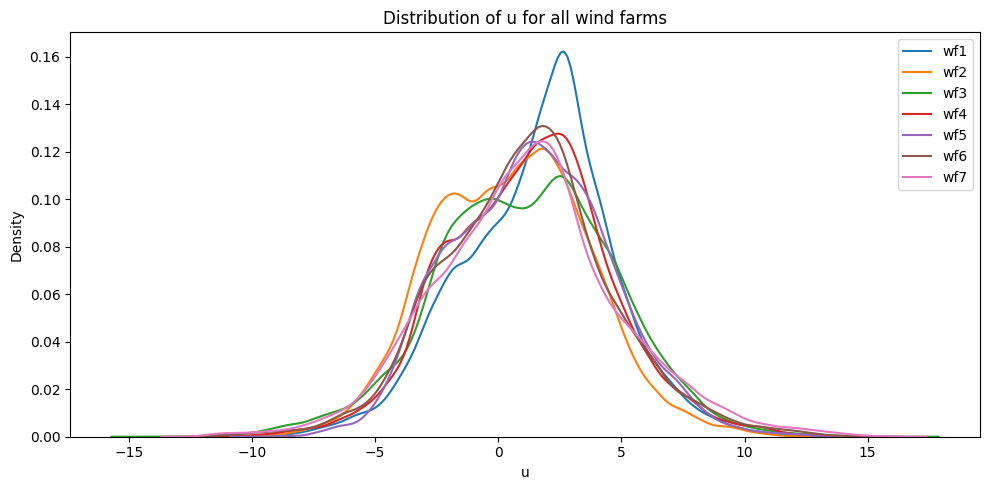

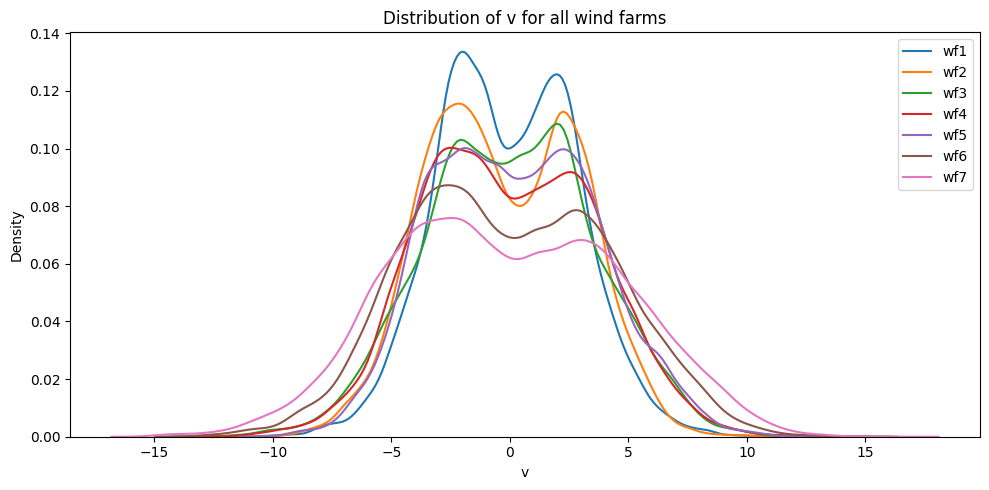

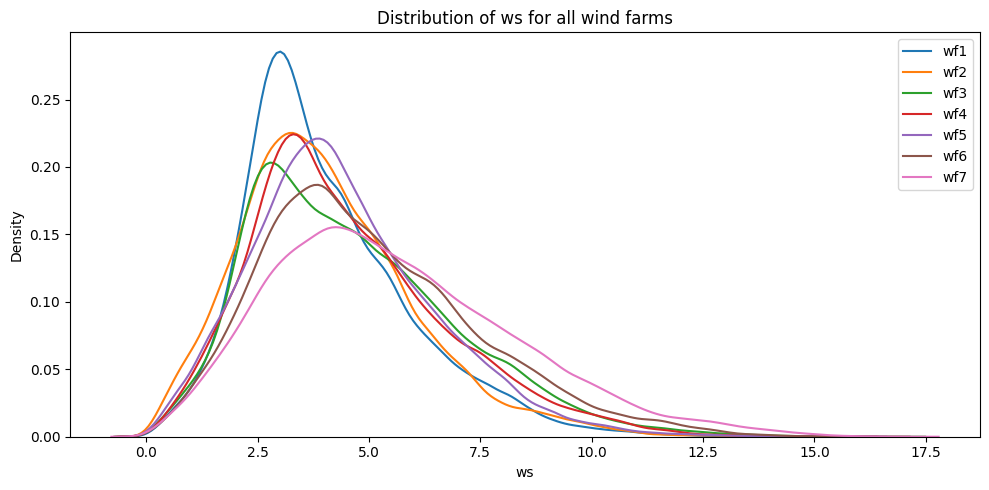

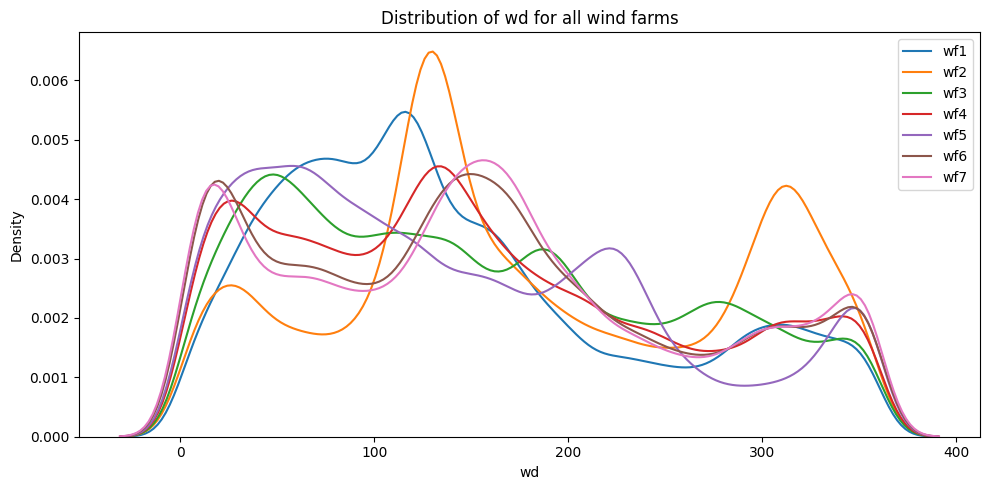

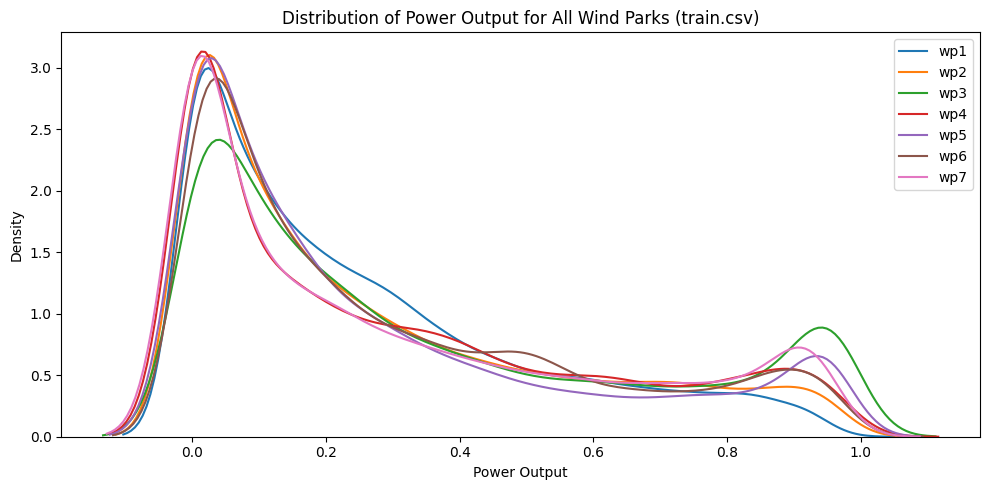

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Overlayed distributions for all wind farms for each forecast variable
variables = ['u', 'v', 'ws', 'wd']
for var in variables:
    plt.figure(figsize=(10, 5))
    for i in range(1, 8):  # wf1 to wf7
        col = f"{var}_wf{i}"
        if col in wf_merged.columns:
            sns.kdeplot(wf_merged[col].dropna(), label=f"wf{i}")
    plt.title(f"Distribution of {var} for all wind farms")
    plt.xlabel(var)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot distributions for all power output columns in train (if present)
power_cols = [col for col in train.columns if col.startswith('wp')]
if power_cols:
    plt.figure(figsize=(10, 5))
    for col in power_cols:
        sns.kdeplot(train[col].dropna(), label=col)
    plt.title("Distribution of Power Output for All Wind Parks (train.csv)")
    plt.xlabel("Power Output")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

**Observations on Feature and Target Distributions:**

- Most features look roughly bell-shaped, but wind speed is a bit right-skewed, meaning there are more low values and a few high ones.
- Power output sometimes shows two peaks, which could be from turbines being either off or running.
- There are some clear outliers, especially in wind speed and power—these might be caused by rare weather events or sensor errors.
- Wind direction seems to be spread out evenly, as expected.
- It’s important to keep these patterns in mind, since outliers and skewness can affect model performance.

###  Feature & Target Distributions – Observations

- **Most features** show unimodal distributions, though some (like *WindSpeed*) are noticeably **right-skewed**.
- KDE curves reveal that **WindPower** may be **bimodal**, likely due to turbine operational states (idle vs. active).
- **Box plots** highlight several **outliers**, especially in wind-related features—possibly due to storms or rare weather events.
- **WindDirection** appears uniformly distributed.



## Possible Biases

[Investigate the dataset for any biases that could affect the model’s performance and fairness (e.g., class imbalance, historical biases).]


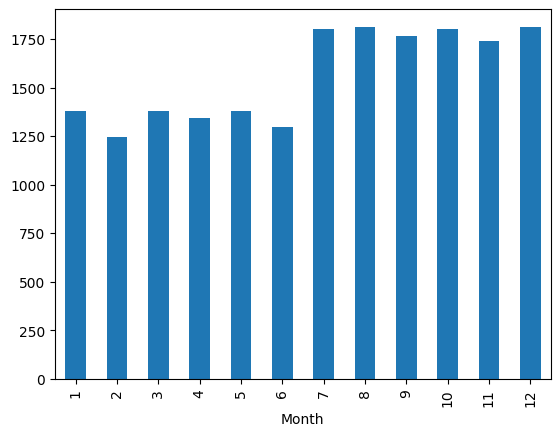

In [82]:
# Example: Checking for class imbalance in a classification problem
# sns.countplot(x='target_variable', data=df)

# Looking for gaps or bias in Time Coverage
# Use the correct DataFrame for time coverage analysis
# Prefer 'train' if it exists, otherwise fallback to 'df'
target_df = train if 'train' in globals() else df

if 'datetime' not in target_df.columns and 'date' in target_df.columns:
    target_df['datetime'] = pd.to_datetime(target_df['date'].astype(str), format='%Y%m%d%H')

if 'datetime' in target_df.columns:
    target_df['Month'] = target_df['datetime'].dt.month
    target_df['Month'].value_counts().sort_index().plot(kind='bar')
else:
    print("No datetime information available for time coverage analysis.")


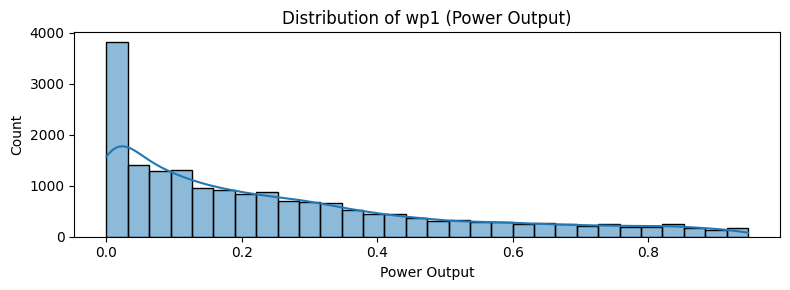

wp1 - Skewness: 1.03, Kurtosis: 0.12
wp1 - Value counts (top 5):
wp1
0.000    2128
0.005     420
0.010     308
0.015     267
0.065     256
Name: count, dtype: int64



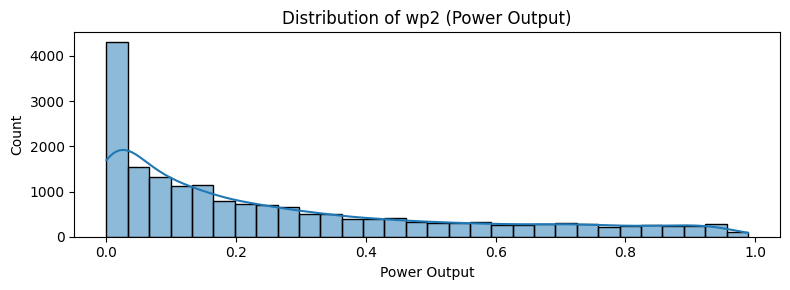

wp2 - Skewness: 1.01, Kurtosis: -0.13
wp2 - Value counts (top 5):
wp2
0.000    2125
0.005     556
0.011     412
0.016     360
0.021     294
Name: count, dtype: int64



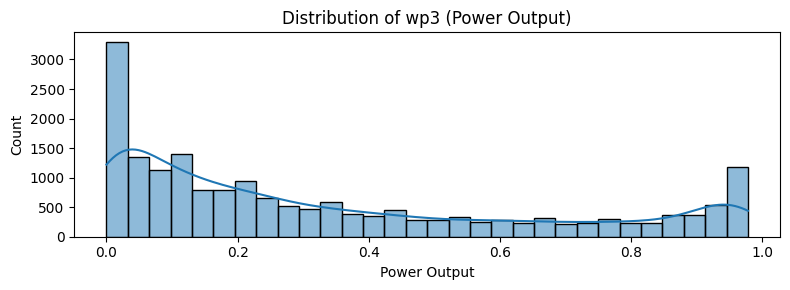

wp3 - Skewness: 0.78, Kurtosis: -0.77
wp3 - Value counts (top 5):
wp3
0.00    1677
0.01     606
0.03     523
0.04     492
0.02     489
Name: count, dtype: int64



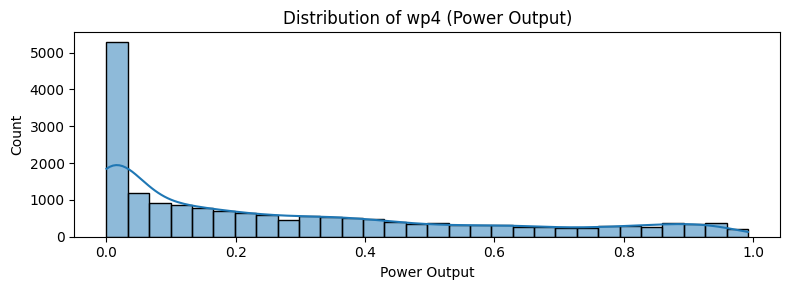

wp4 - Skewness: 0.86, Kurtosis: -0.51
wp4 - Value counts (top 5):
wp4
0.000    3324
0.006     551
0.011     363
0.017     282
0.028     269
Name: count, dtype: int64



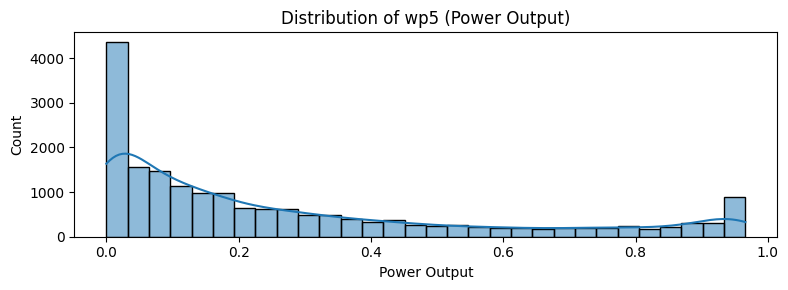

wp5 - Skewness: 1.10, Kurtosis: -0.04
wp5 - Value counts (top 5):
wp5
0.000    2181
0.005     544
0.010     397
0.015     341
0.020     302
Name: count, dtype: int64



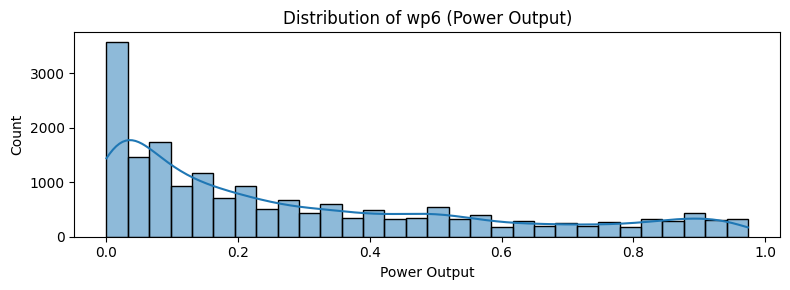

wp6 - Skewness: 0.94, Kurtosis: -0.31
wp6 - Value counts (top 5):
wp6
0.000    1649
0.013    1021
0.026     907
0.039     778
0.053     686
Name: count, dtype: int64



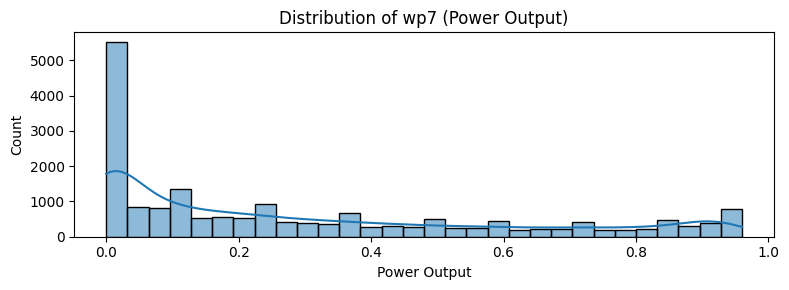

wp7 - Skewness: 0.85, Kurtosis: -0.62
wp7 - Value counts (top 5):
wp7
0.000    4380
0.025    1137
0.051     830
0.076     819
0.934     700
Name: count, dtype: int64



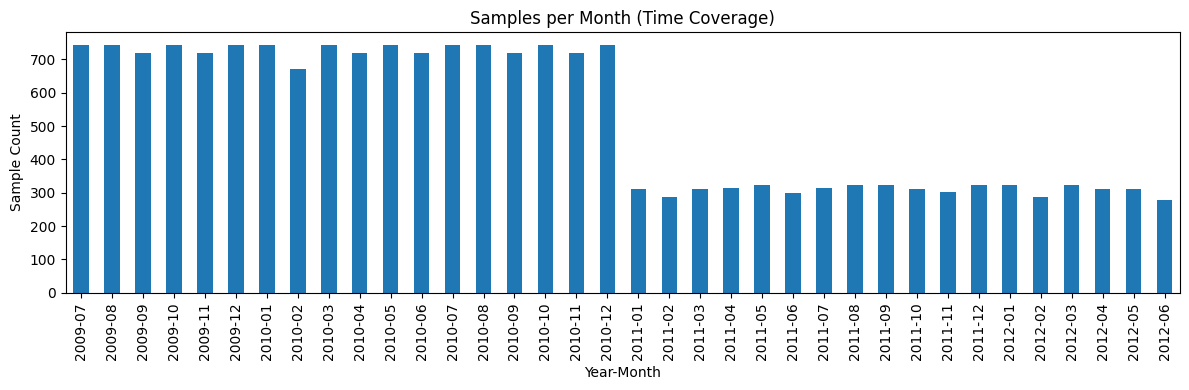

In [83]:
# Check for class imbalance in power output (regression target)
# For regression, visualize the distribution and check for rare/extreme values
if power_cols:
    for col in power_cols:
        plt.figure(figsize=(8, 3))
        sns.histplot(train[col], bins=30, kde=True)
        plt.title(f"Distribution of {col} (Power Output)")
        plt.xlabel("Power Output")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()
        print(f"{col} - Skewness: {train[col].skew():.2f}, Kurtosis: {train[col].kurtosis():.2f}")
        print(f"{col} - Value counts (top 5):\n{train[col].value_counts().head()}")
        print()
else:
    print("No power output columns found for class imbalance check.")

# Check for historical bias: Are there periods with much more or less data?
if 'datetime' in target_df.columns:
    target_df['YearMonth'] = target_df['datetime'].dt.to_period('M')
    target_df['YearMonth'].value_counts().sort_index().plot(kind='bar', figsize=(12, 4))
    plt.title('Samples per Month (Time Coverage)')
    plt.xlabel('Year-Month')
    plt.ylabel('Sample Count')
    plt.tight_layout()
    plt.show()
else:
    print("No datetime information available for historical bias analysis.")

## Correlations

This section explores correlations between features and the target variable, as well as among features themselves. A heatmap is used for visualization.

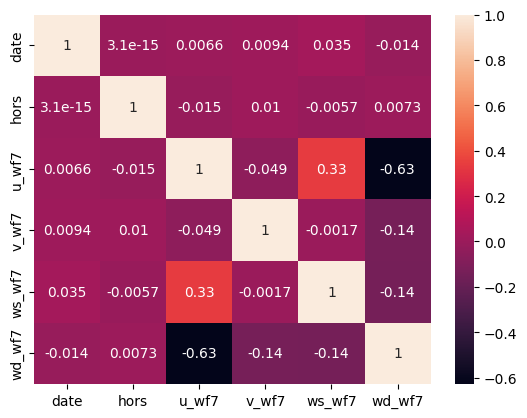

In [84]:
# Plotting a heatmap to show feature correlations
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()